In [4]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle

import awkward as ak
import mplhep as hep
import argparse     # to get arguments from command line executing file.py
import os # read directories etc.
from scipy.signal import find_peaks, gaussian
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import pylandau
import re

verbose = False
debug = False

In [3]:
def tree_to_df(tree, branches):
    """
    Converts tree object from a file.root into pandas DataFrame unpacking branches with multiple channels
    into 'Branch_0', 'Branch_1' etc.
    """
    df_ak = tree.arrays(branches, library='ak') # changed library from pd (pandas) to ak (awkward)
    df_ak = ak.to_dataframe(df_ak)  # multiindexed DataFrame
    df_ak = df_ak.swaplevel().sort_index(level='subentry')
    df = pd.DataFrame()
    
    for name in branches: # converts all multiindexed entries into Entry_0, Entry_1 etc.
        for idx in df_ak.index.unique(0):
            new_columns = pd.DataFrame(df_ak.xs(idx)[name])  # df_ak.xs(idx) is Xtr[idx]
            new_columns.columns = [f'{name}_{idx}']   # rename it to Xtr_idx
            df = pd.concat([df, new_columns], axis=1)
    return df

def plot_histogram(data, poisson_err=False, bins='auto', label=None):
    """
    Plot a simple (list of) histogram with optionally the poissonian error.
    Returns 'figure' and 'axis' so that more hist/plots can be added
    """
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    ax.grid('--')
    hist_points, bins_points, _ = ax.hist(data, bins=bins, histtype='step', label=label)
    if (poisson_err):      # adding the poissonian error (sqrt(hist_point)
        bins_centers = (bins_points[1:]+bins_points[:-1])/2
        if (np.shape(np.shape(data))[0]>1): # a bit convoluted but checks the dimensions of the data
            for single_hist in hist_points:     # in case data is a list of data
                ax.errorbar(bins_centers, single_hist, yerr=single_hist**0.5, elinewidth=2, marker='.', linewidth=0, alpha=0.7)
        else:
            ax.errorbar(bins_centers, hist_points, yerr=hist_points**0.5, elinewidth=2, marker='.', linewidth=0, alpha=0.7)
    return fig, ax

def add_histogram(ax, data, bins='auto', label=None):
    ax.hist(data, bins=bins, histtype='step', label=label)
    
def find_min_btw_peaks(data, bins, prominence, distance, plot=True):
    """Finds the minimun between two peaks, returns x position of min"""
    hist, bins_hist, _ = plt.hist(data, bins=bins, histtype='step')
    bins_centers = (bins_hist[1:]+bins_hist[:-1])/2
    peaks_idx, _ = find_peaks(hist, prominence=prominence, distance=distance)
    plt.plot(bins_centers[peaks_idx], hist[peaks_idx], "x")
    try:
        global_min, _ = find_peaks(-hist[peaks_idx[0]:peaks_idx[-1]], prominence=prominence, distance=distance)
    except:
        print("Didn't find 2 peaks")
        return
    plt.plot(bins_centers[global_min+peaks_idx[0]], hist[global_min+peaks_idx[0]], "o")
    if not plot: plt.close()
    x_min = bins_centers[global_min+peaks_idx[0]][0]
#     y_min = hist[global_min+peaks_idx[0]][0]
    return  x_min#, y_min


In [4]:

# Load the dataframe of sensor names
sensor_list_file = "sensors_list.pickle"
with open(sensor_list_file, 'rb') as f:
    sensors_list = pickle.load(f)
    
if verbose: print(sensors_list)


# I wanna save data from both scopes
this_batch = 301
branches = ["Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]

dir_path = {} 
df = {}  # dictionary containing the two dataframes of the two oscilloscopes
for S in ["S1","S2"]: # the two scopes
    dir_path[S] = f"../Data_TestBeam/2023_May/{S}/"
    file_path = f"tree_May2023_{S}_{this_batch}.root"
    tree = uproot.open(os.path.join(dir_path[S], file_path)+":tree")
    df[S] = tree_to_df(tree, branches)


NameError: name 'uproot' is not defined

['MCP', 'USTC2.1-W17-P6-A', 'USTC2.1-W17-P6-A', 'IMEv3-W12-C3-1-4']


Text(0.5, 1.0, 'Single sensor time distribution with pulseheight cut, batch:301 (CFD70)')

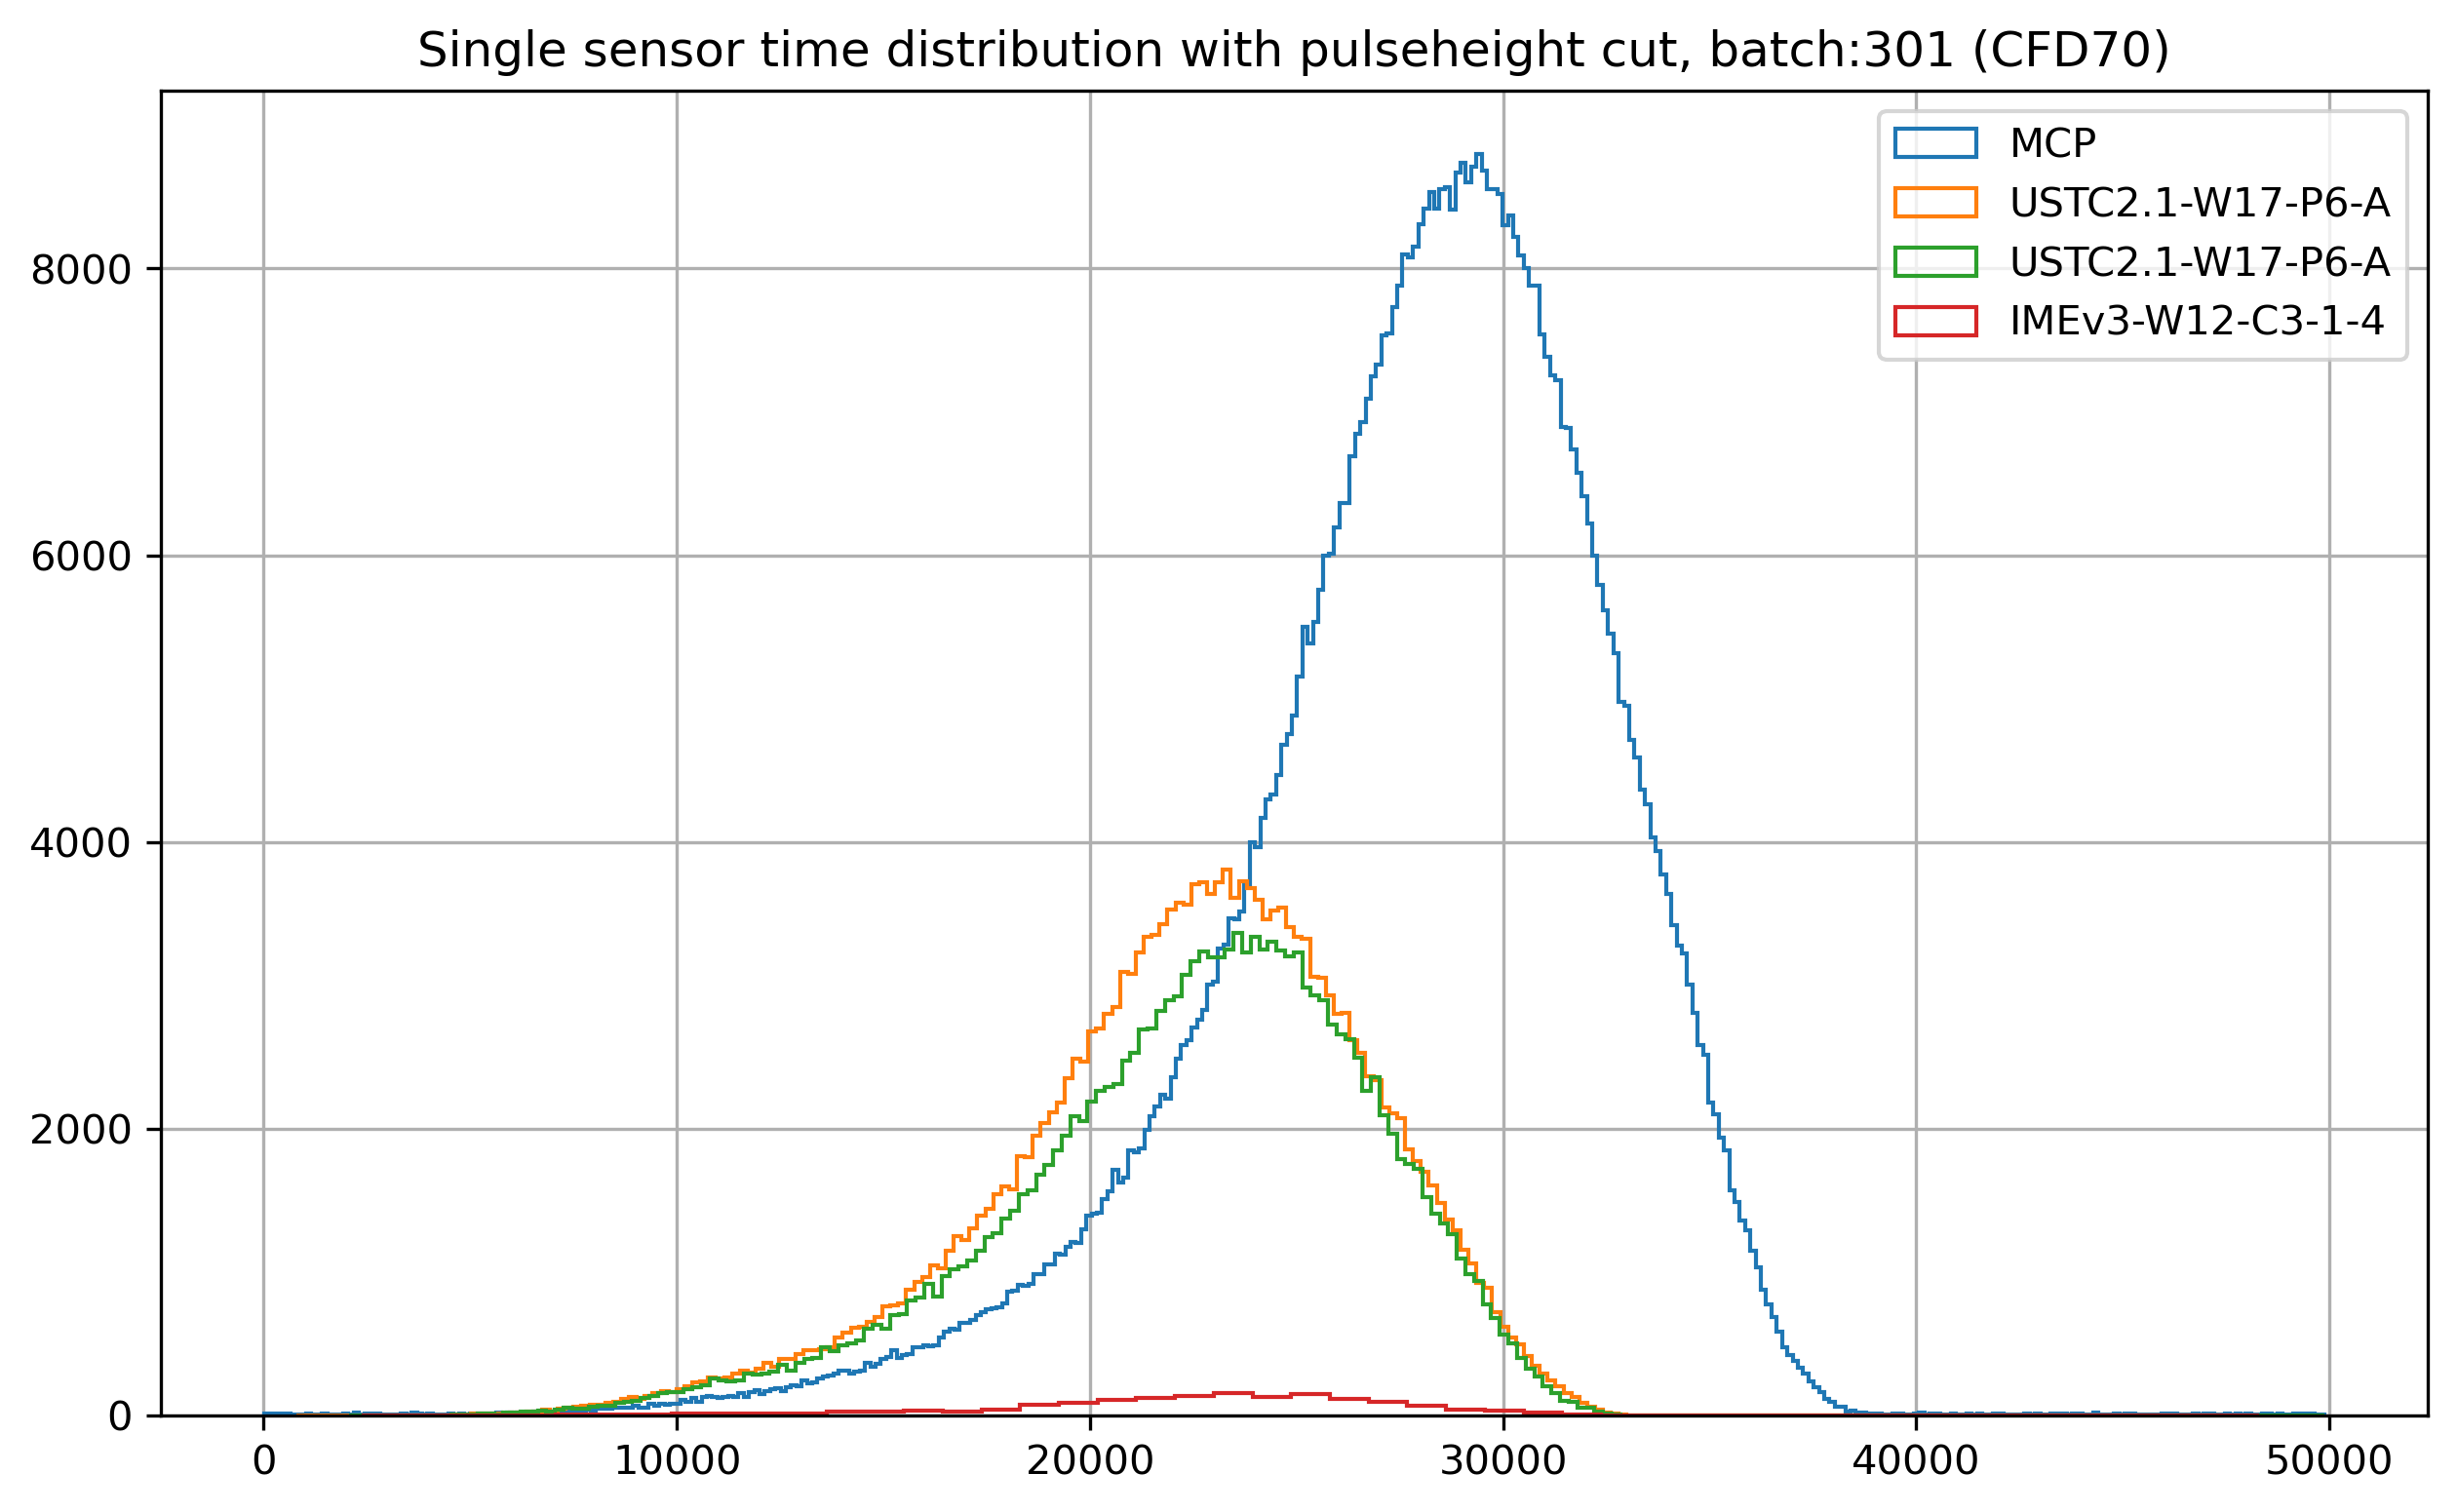

In [19]:
# Get the sensors names
this_scope = "S1"
these_sensors = list(sensors_list[this_batch][this_scope].values())
print(these_sensors)
CFD = 70
pulseheight_cut = [21.2, 18.5, 9.5]  #these values are still quite approximate

# Plot the time of constant fraction discriminator (50%)
fig, ax = plot_histogram(df[this_scope][f"timeCFD{CFD}_0"], label=these_sensors[0])
for i in range(1,4):
    add_histogram(ax, df[this_scope][f"timeCFD{CFD}_{i}"].iloc[np.where(df[this_scope][f"pulseHeight_{i}"]>pulseheight_cut[i-1])], label=these_sensors[i])
ax.legend()
ax.set_title(f"Single sensor time distribution with pulseheight cut, batch:{this_batch} (CFD{CFD})")

# fig.savefig(f"various plots/single_time_with_cut_res_batch{this_batch}_CDF{CFD}.jpg")

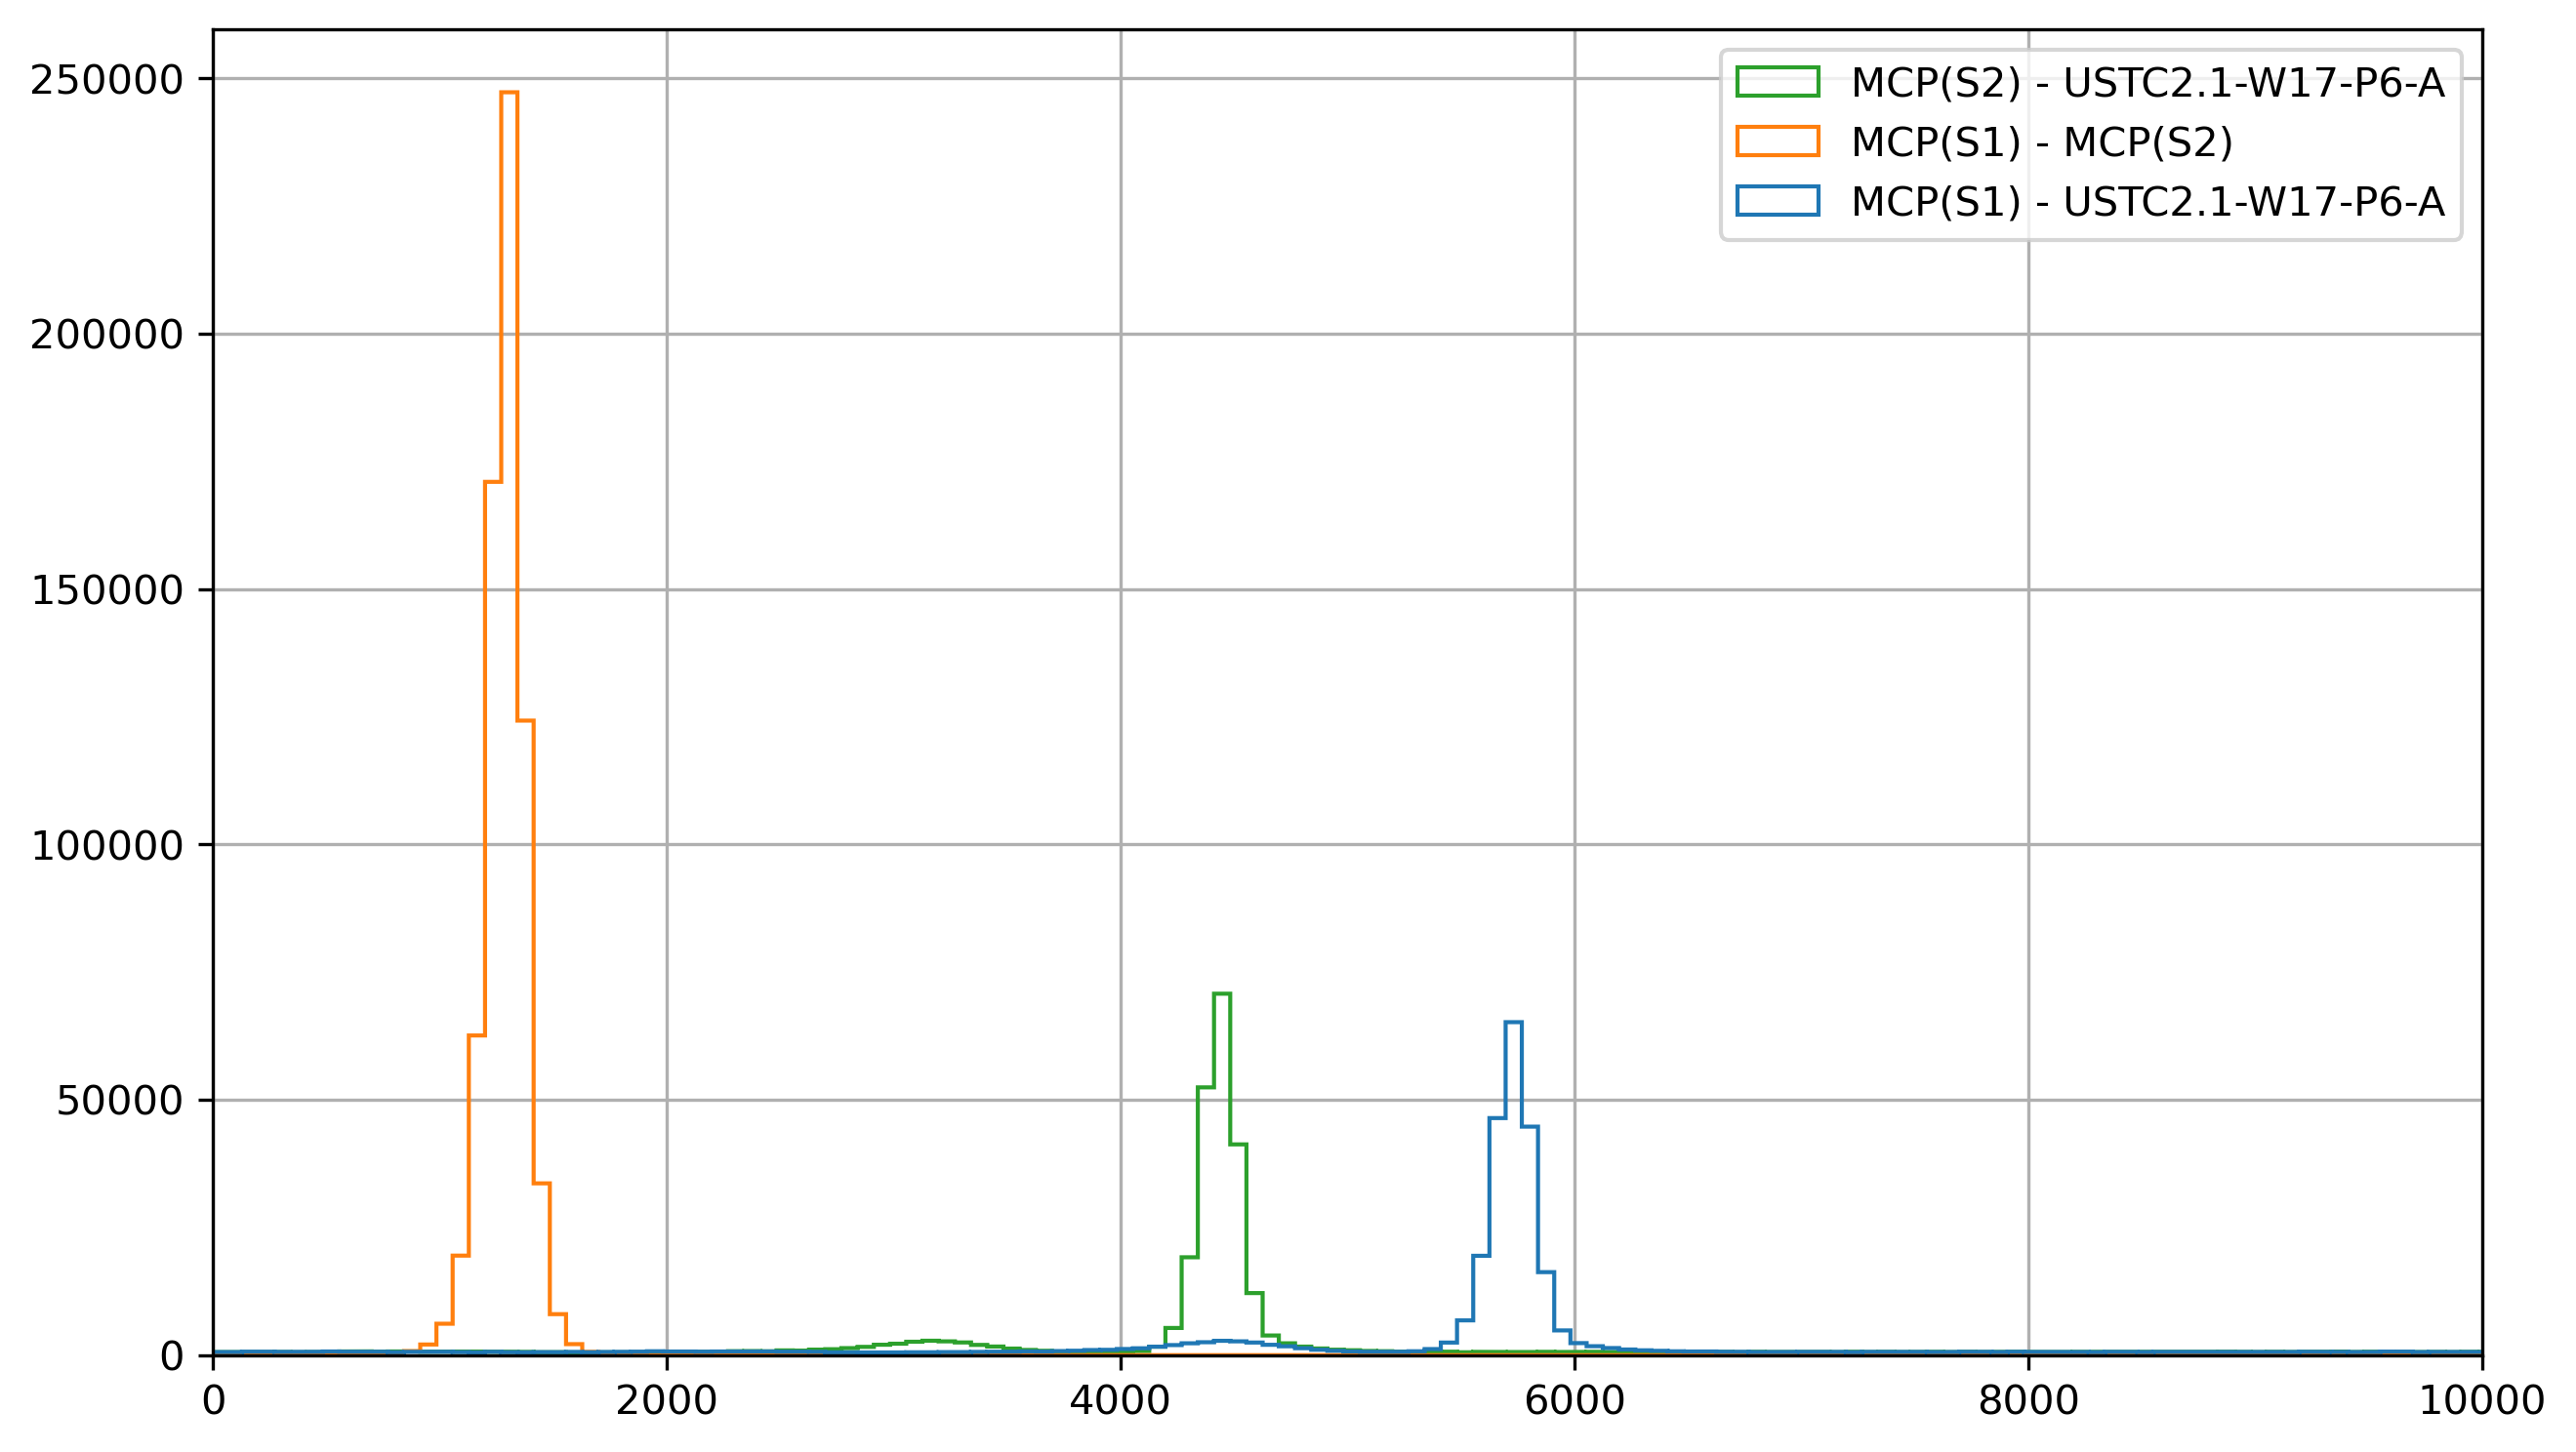

In [46]:
# plot the time of MCP for S1 and S2
t_1 = df["S1"]["timeCFD20_0"]
t_3 = df["S1"]["timeCFD20_1"]
t_4 = df["S2"]["timeCFD20_0"]
labels = (f'{these_sensors["S1"]["Ch1"]}(S1) - {these_sensors["S1"]["Ch2"]}',
         f'{these_sensors["S1"]["Ch1"]}(S1) - {these_sensors["S2"]["Ch1"]}(S2)',
         f'{these_sensors["S2"]["Ch1"]}(S2) - {these_sensors["S1"]["Ch2"]}')
these_sensors = sensors_list[this_batch]
fig, ax = plot_histogram((t_1-t_3, t_1-t_4, t_4-t_3 ),
                         label=labels)
ax.set_xlim(0,1e4)

ax.legend()

(<Figure size 3000x1800 with 1 Axes>, <AxesSubplot:>)

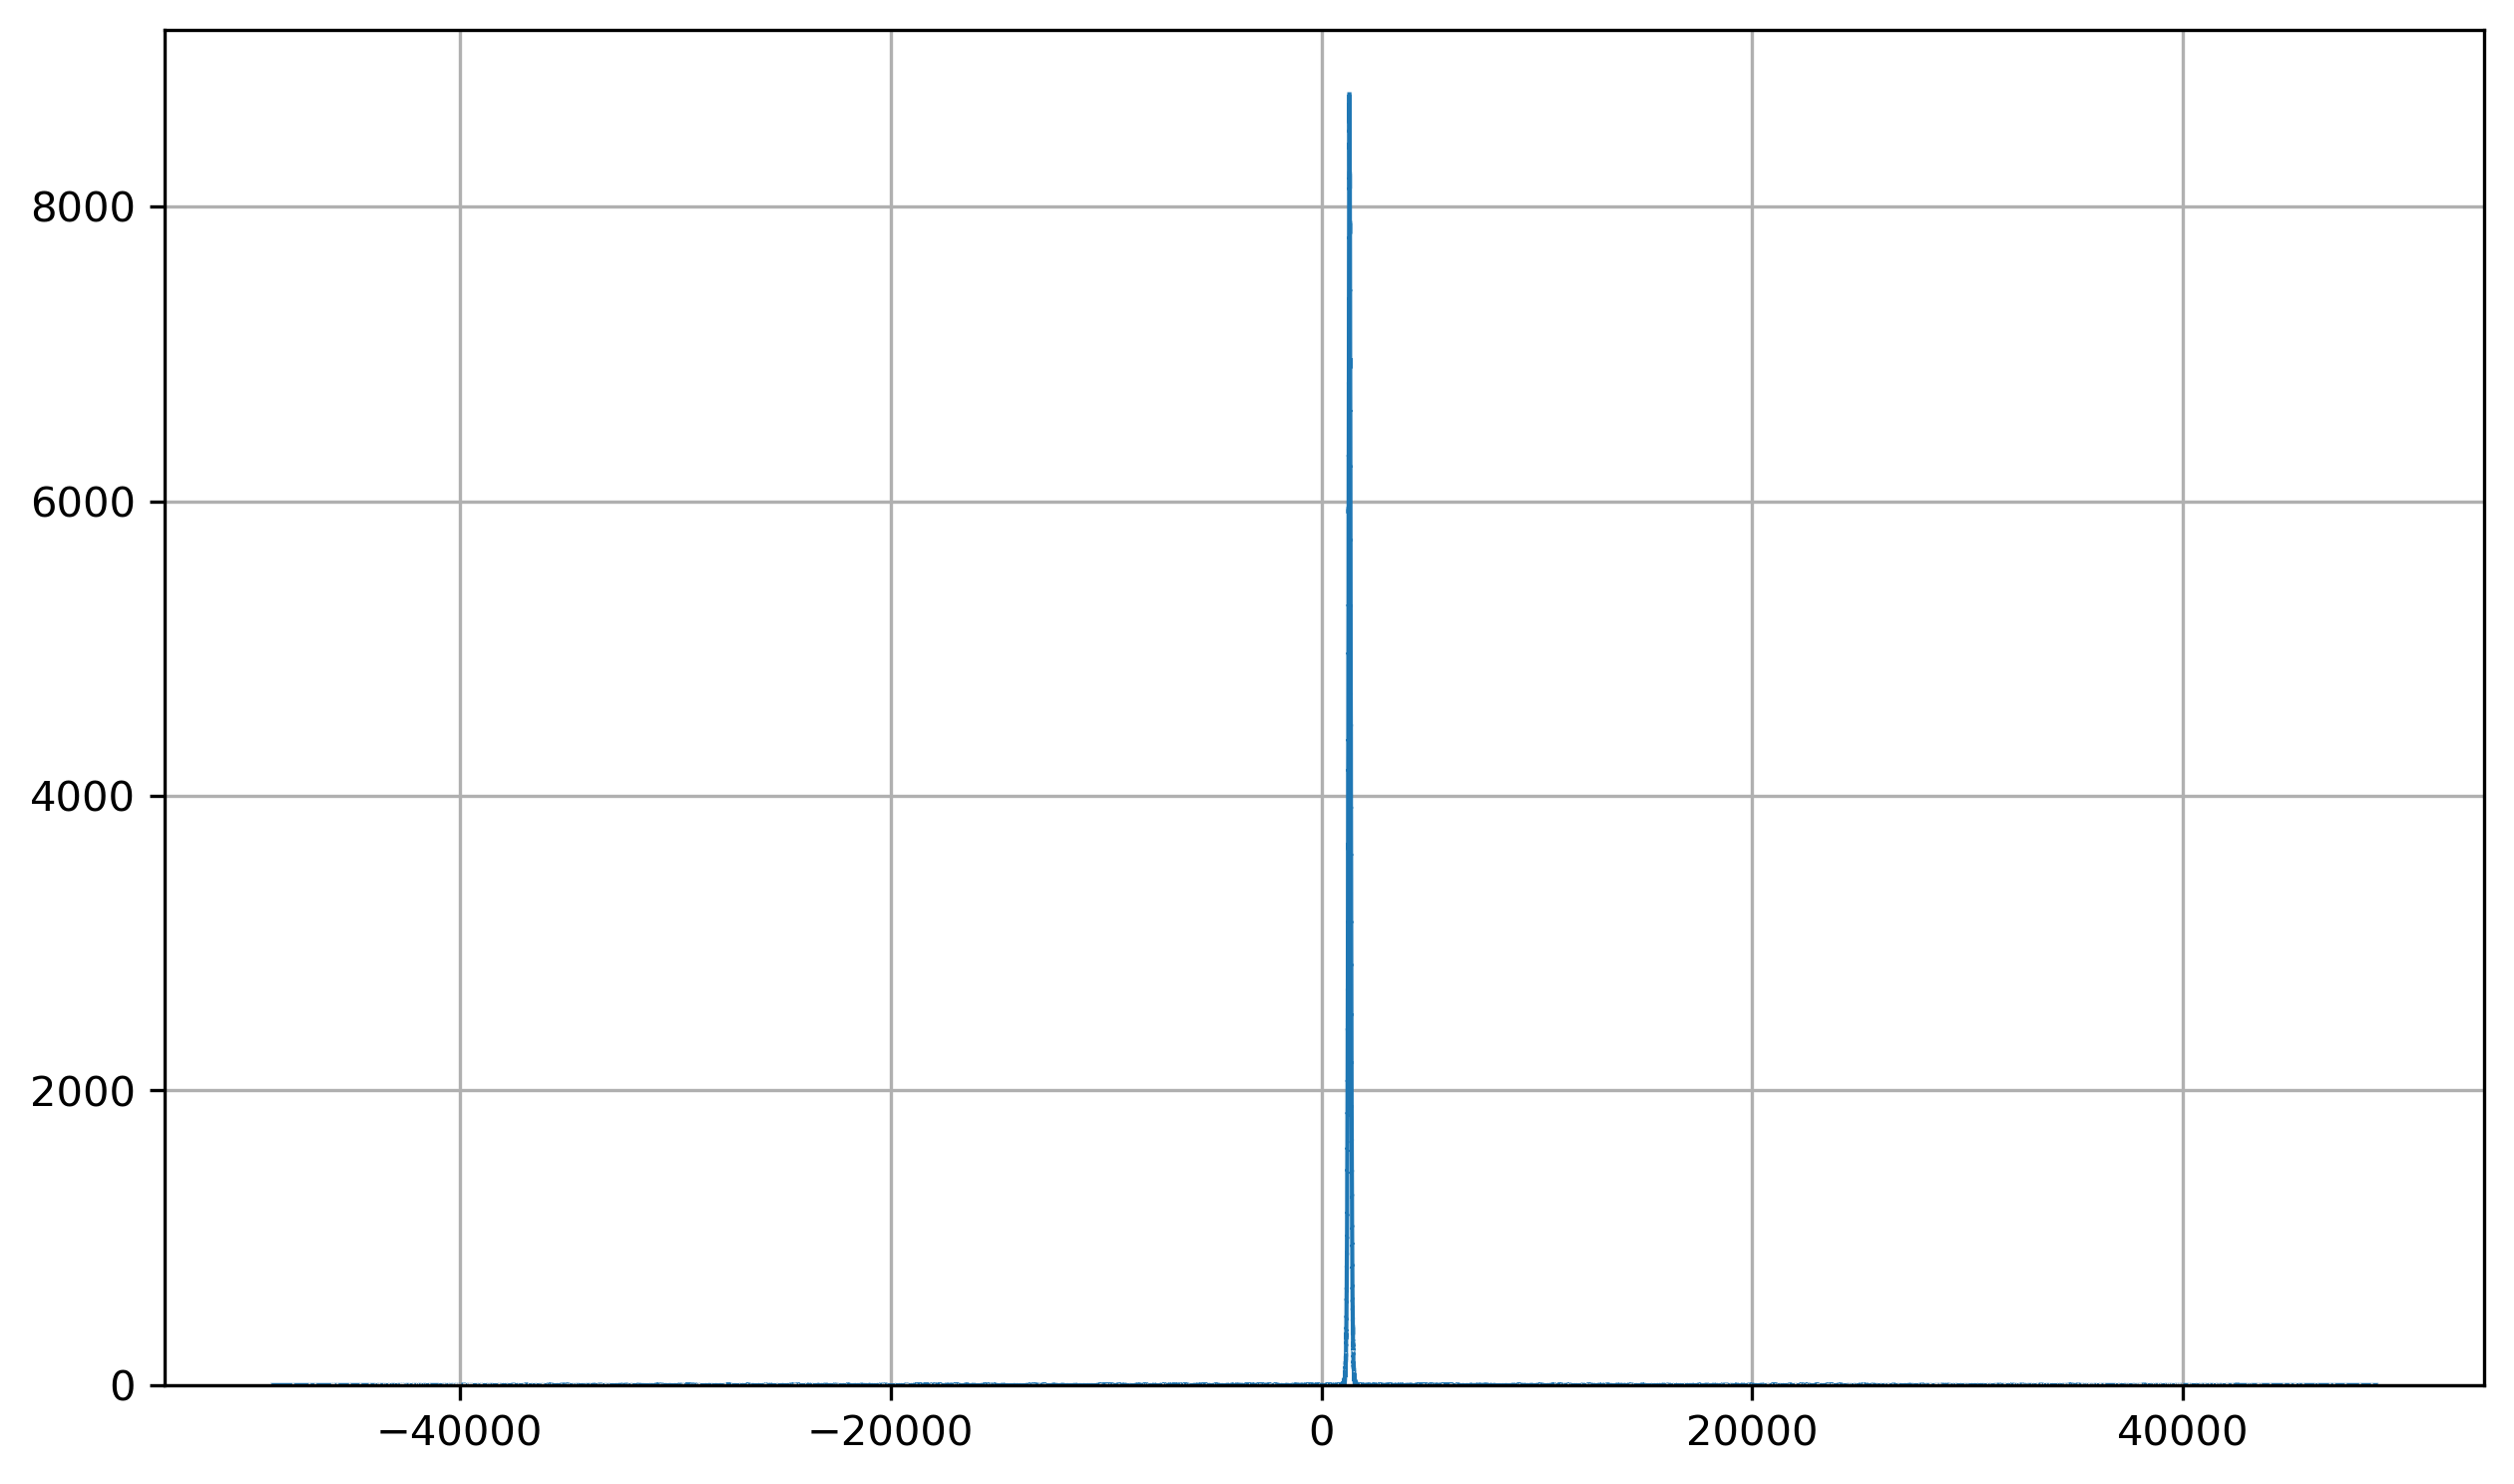

In [38]:
fig, ax = plot_histogram(df["S1"]["timeCFD70_0"]-df["S2"]["timeCFD70_0"])
ax

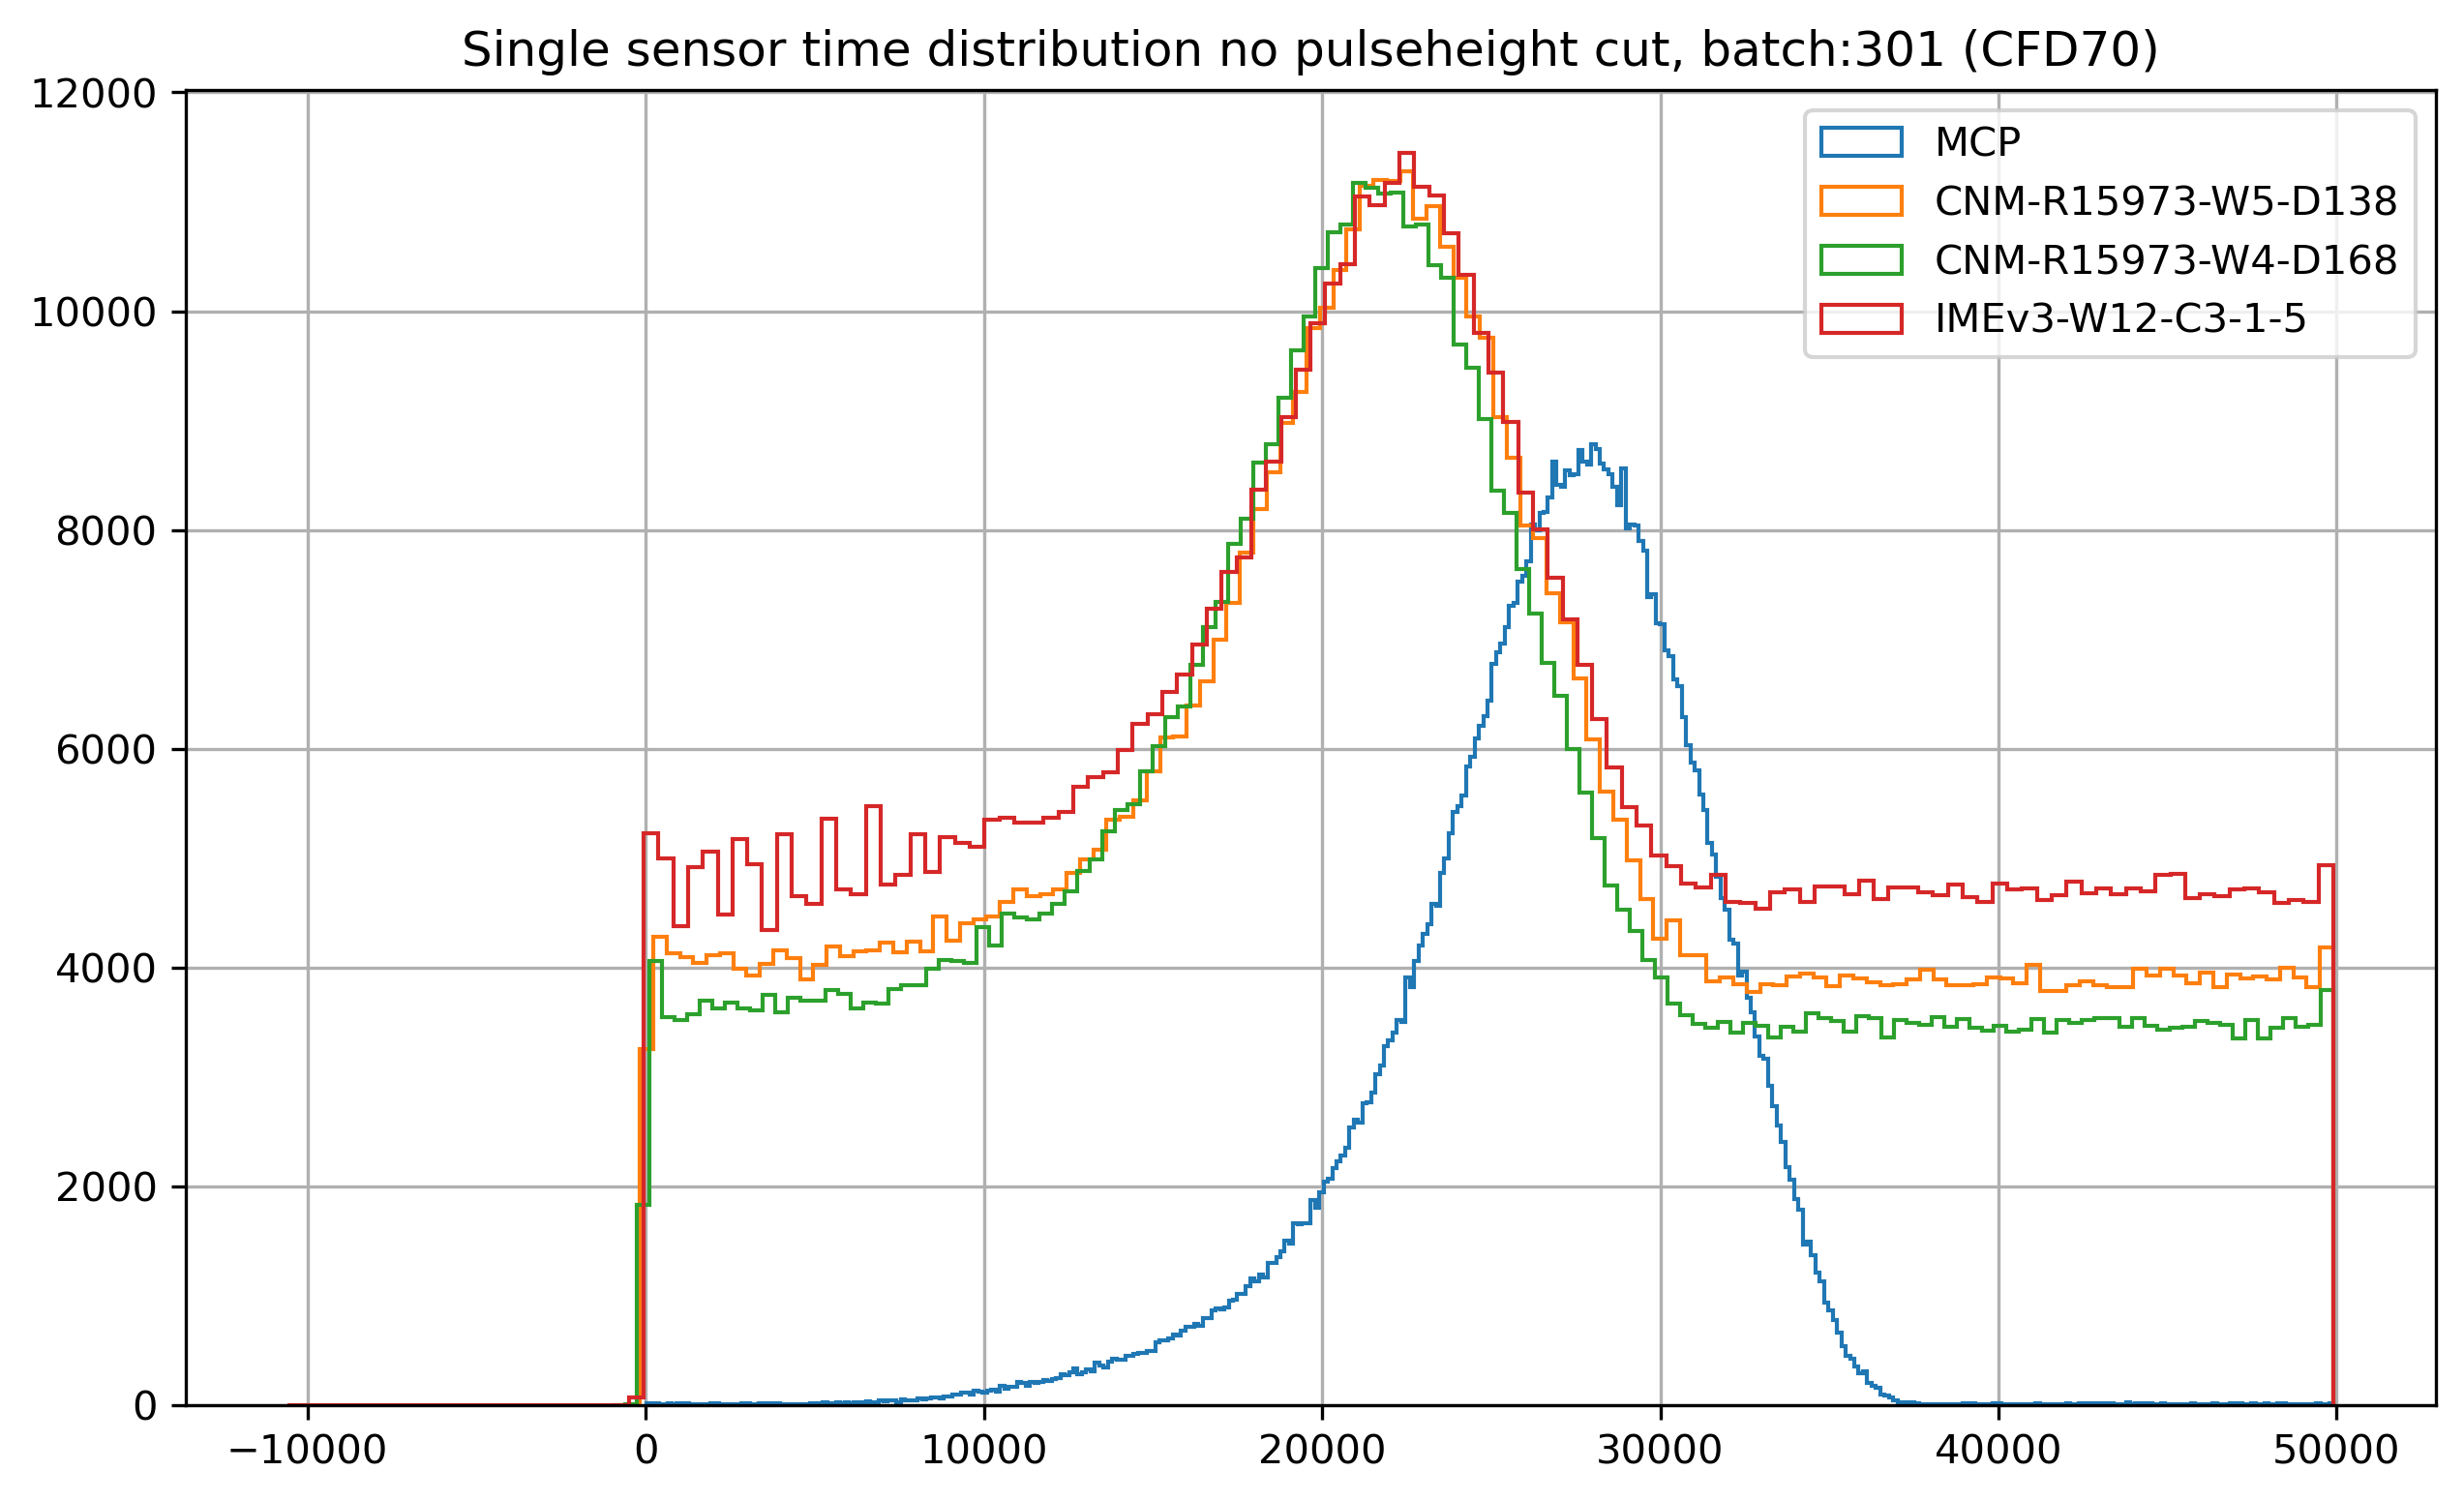

In [136]:
# Plot the time of constant fraction discriminator (50%)
fig, ax = plot_histogram(df[f"timeCFD{CFD}_0"], label=these_sensors[0])
for i in [1,2,3]:
    add_histogram(ax, df[f"timeCFD{CFD}_{i}"], label=these_sensors[i])
ax.legend()
ax.set_title(f"Single sensor time distribution no pulseheight cut, batch:{this_batch} (CFD{CFD})")

fig.savefig(f"various plots/single_time_no_cut_res_batch{this_batch}_CDF{CFD}.jpg")

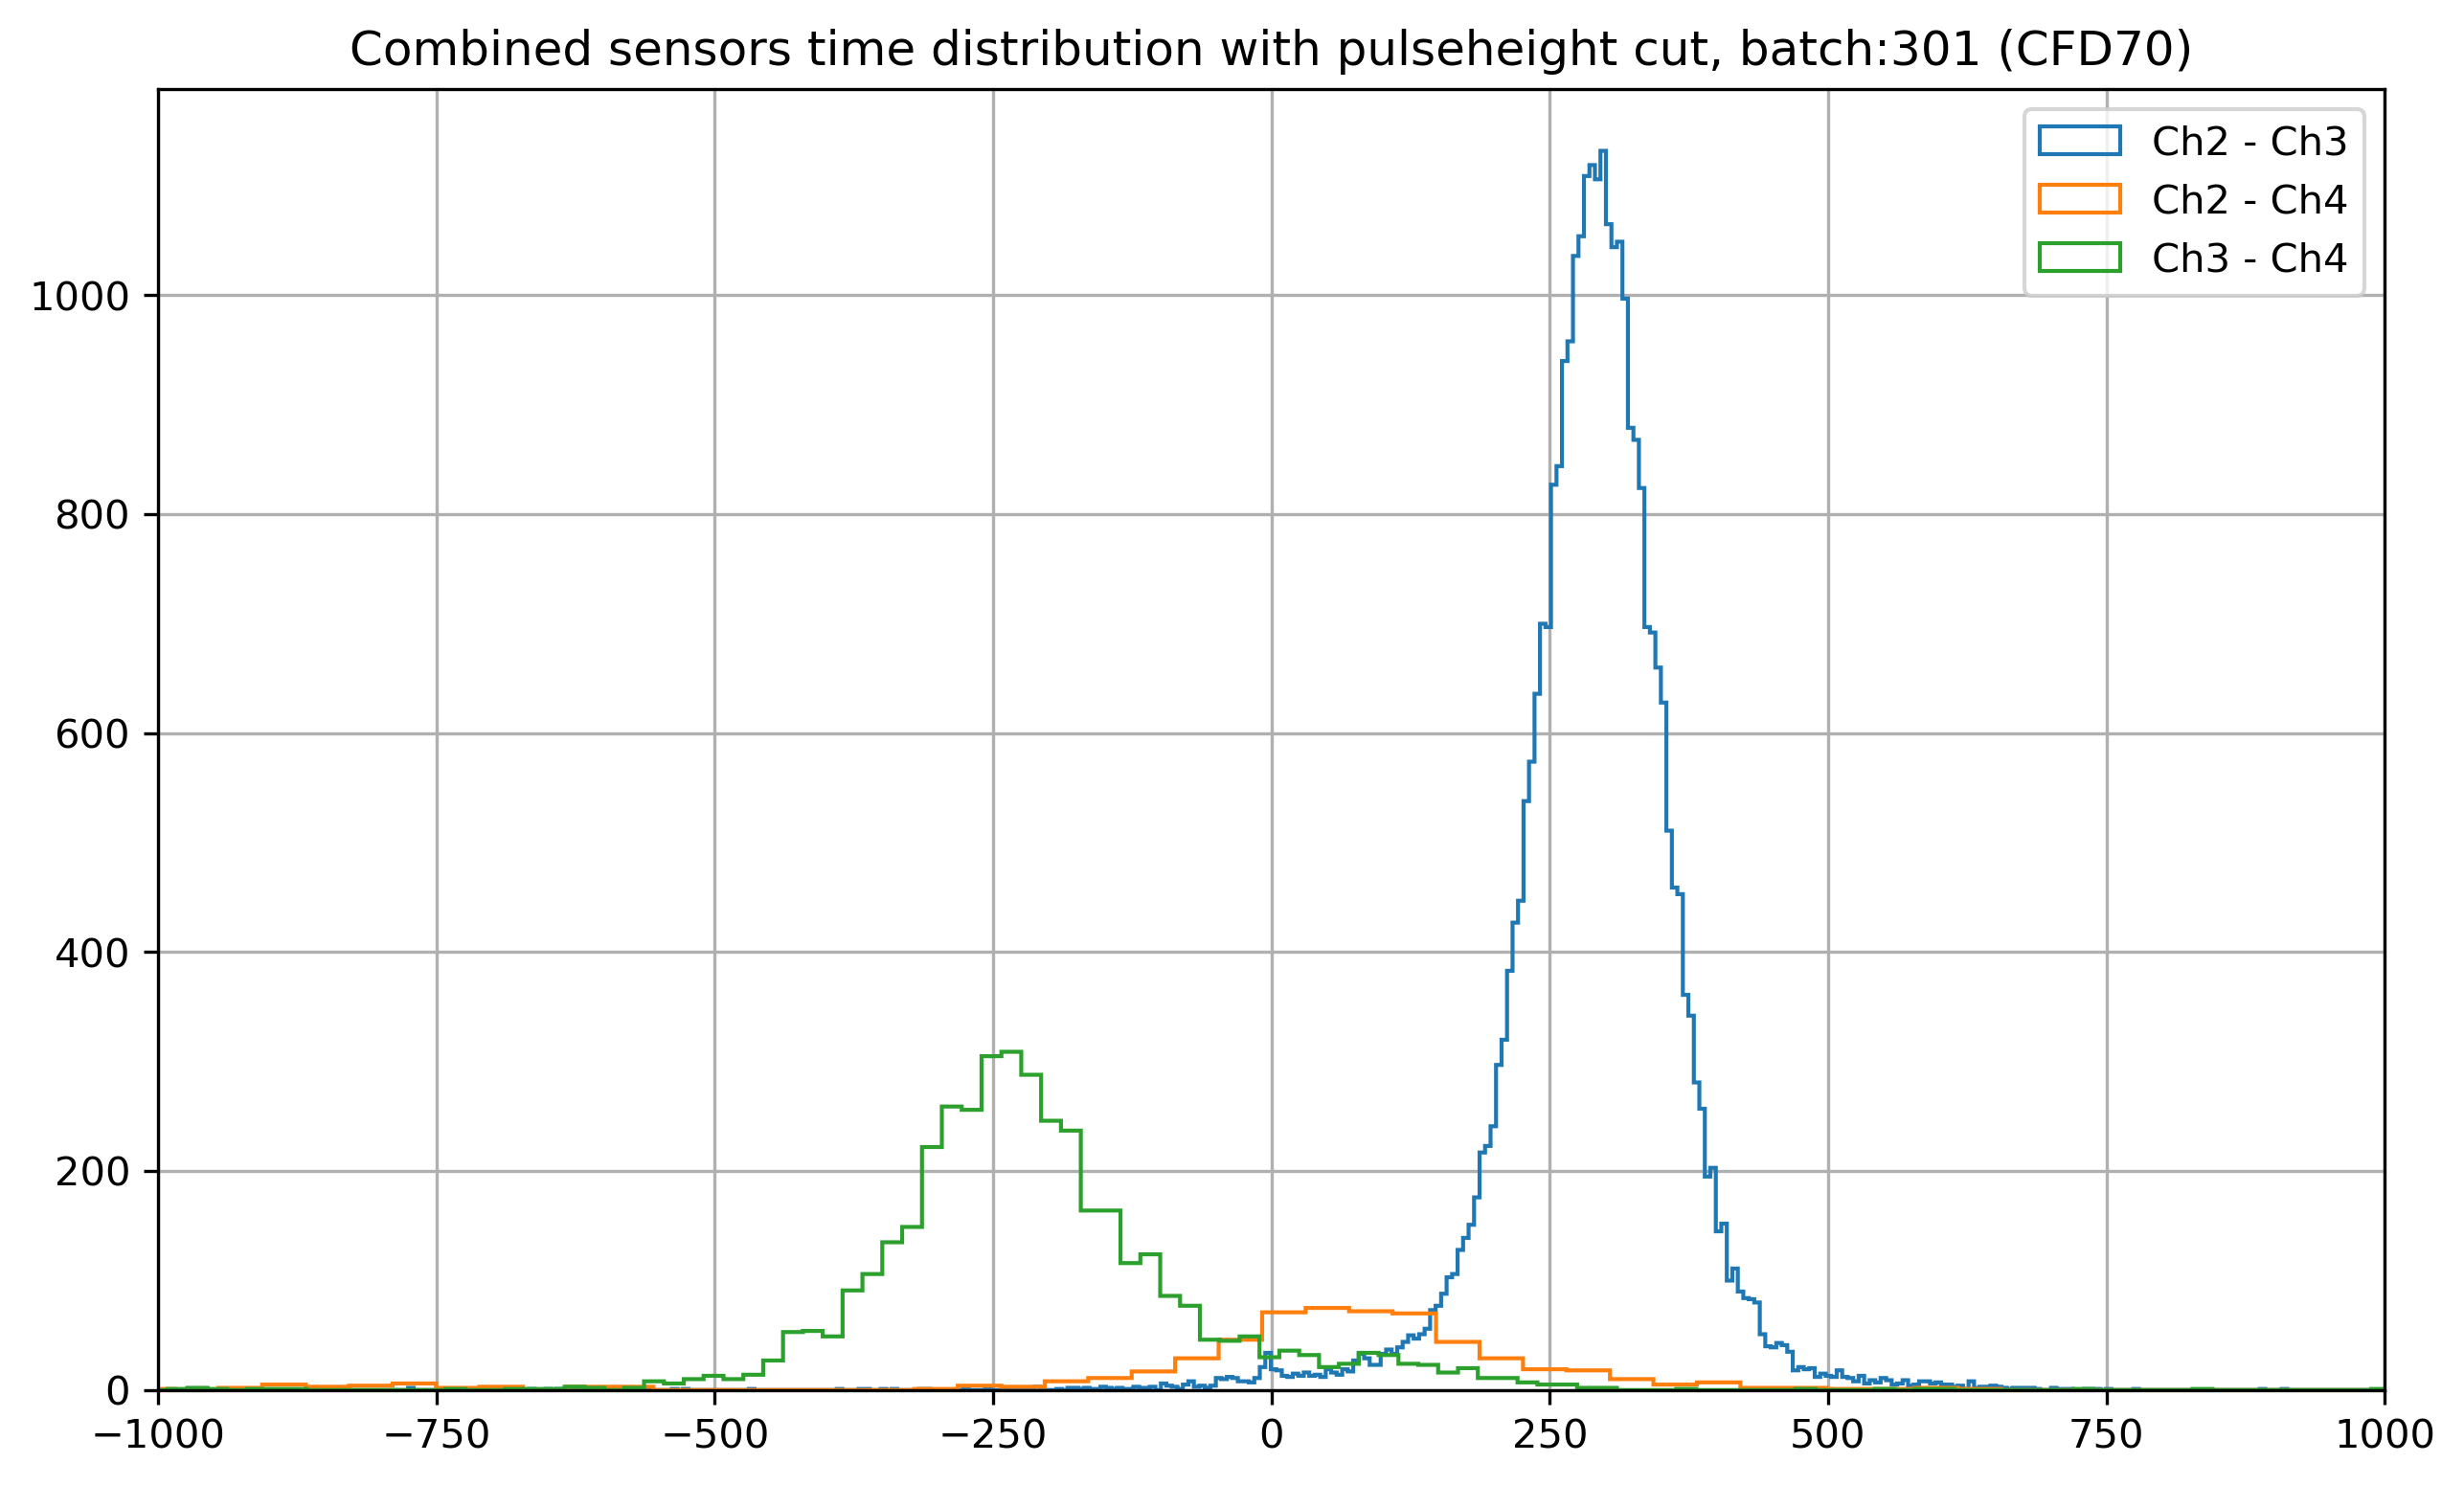

In [135]:
bins = 'auto'
fig, ax = plot_histogram(df[f"timeCFD{CFD}_1"].iloc[np.where(df[f"pulseHeight_1"]>pulseheight_cut[0])]-df[f"timeCFD{CFD}_2"].iloc[np.where(df[f"pulseHeight_2"]>pulseheight_cut[1])], bins=bins, label=f"Ch2 - Ch3")
add_histogram(ax, df[f"timeCFD{CFD}_1"].iloc[np.where(df[f"pulseHeight_1"]>pulseheight_cut[0])]-df[f"timeCFD{CFD}_3"].iloc[np.where(df[f"pulseHeight_3"]>pulseheight_cut[2])], bins=bins, label=f"Ch2 - Ch4")
add_histogram(ax, df[f"timeCFD{CFD}_2"].iloc[np.where(df[f"pulseHeight_2"]>pulseheight_cut[1])]-df[f"timeCFD{CFD}_3"].iloc[np.where(df[f"pulseHeight_3"]>pulseheight_cut[2])], bins=bins, label=f"Ch3 - Ch4")
ax.set_xlim(-1000, 1000)
ax.legend()
# df["timeCFD50_0"] - df["timeCFD50_2"]
ax.set_title(f"Combined sensors time distribution with pulseheight cut, batch:{this_batch} (CFD{CFD})")
fig.savefig(f"various plots/combined_time_res{this_batch}_CDF{CFD}.jpg")